In [144]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
db = mysql.connector.connect(host="localhost", user="root", password="Root123_", database="droptime")

In [3]:
query1 = """
select product_id as productId, weight*quantity as totalWeight from orders
join orders_products using(order_id)
join products using(product_id)
join route_segments using(order_id)
where customer_id=32 and segment_end_time between '2024-02-13' and '2024-02-14'
order by totalWeight
"""
pd.read_sql(query1, db).to_csv("Bartosz_Pobudejski.csv")

In [4]:
query1 = """
select TIMESTAMPDIFF(minute, segment_start_time, segment_end_time) as deliveryTimeMinutes, 
TIMESTAMPDIFF(second, segment_start_time, segment_end_time) as deliveryTimeSeconds,
cast(round(abs((TIMESTAMPDIFF(second, segment_start_time, segment_end_time)-planned_delivery_duration)/60)) as unsigned) as deliveryError
from route_segments
join orders using(order_id)
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 
and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)<30
order by deliveryTimeSeconds desc
"""

Text(0.5, 0, 'Delivery length in minutes')

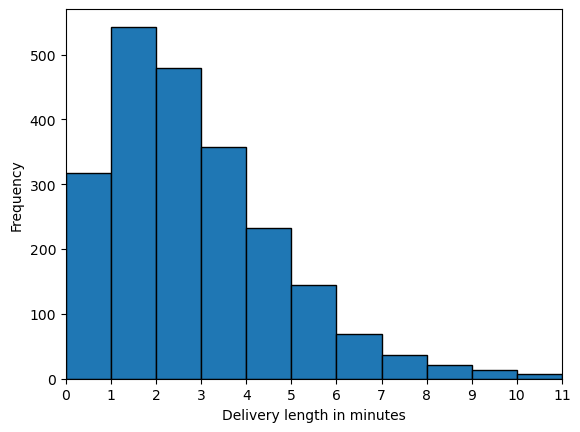

In [5]:
deliveryTimes = pd.read_sql(query1, db)
deliveryTimes.deliveryTimeMinutes.plot.hist(
                        bins=range(deliveryTimes.deliveryTimeMinutes.min(), deliveryTimes.deliveryTimeMinutes.max()+1), 
                        xticks=(range(deliveryTimes.deliveryTimeMinutes.min(), deliveryTimes.deliveryTimeMinutes.max()+1)),
                        xlim=[deliveryTimes.deliveryTimeMinutes.min(), deliveryTimes.deliveryTimeMinutes.max()],
                        edgecolor='black'
                       )
plt.xlabel("Delivery length in minutes")

0       9
1       9
2       8
3       8
4       8
       ..
2218    3
2219    3
2220    3
2221    3
2222    3
Name: deliveryError, Length: 2223, dtype: int64

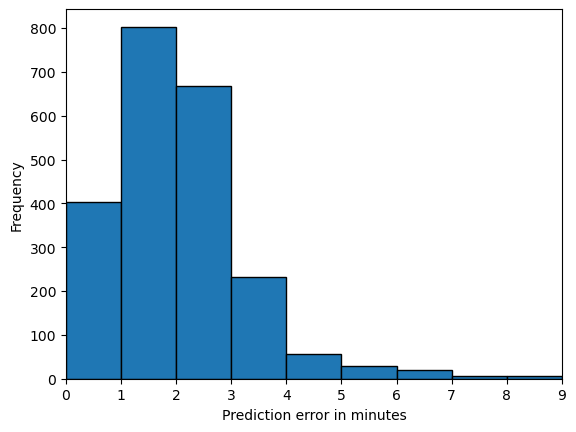

In [10]:
deliveryErrors = deliveryTimes.deliveryError
deliveryErrors.plot.hist(
                        bins=range(deliveryErrors.min(), deliveryErrors.max()+1), 
                        xticks=(range(deliveryErrors.min(), deliveryErrors.max()+1)),
                        xlim=[deliveryErrors.min(), deliveryErrors.max()],
                        edgecolor='black'
                        )
plt.xlabel("Prediction error in minutes")
deliveryErrors

Text(0.5, 0, 'Sector')

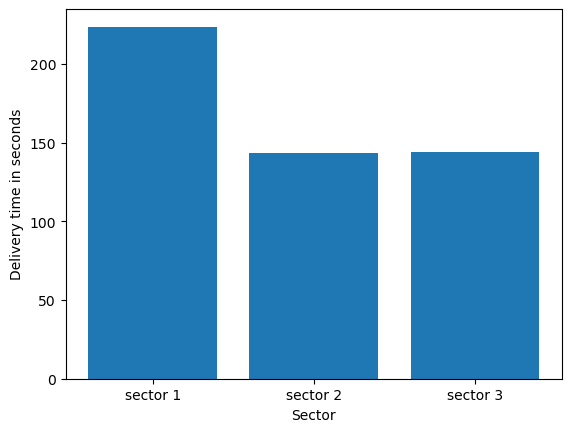

In [13]:
query = """
select avg(TIMESTAMPDIFF(second, segment_start_time, segment_end_time)) as average, sector_id
from route_segments
join orders using(order_id)
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 and 
TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)<30 
group by sector_id
order by sector_id
"""
sectorDelivery = pd.read_sql(query, db)
plt.bar([f"sector {i}" for i in sectorDelivery.sector_id], sectorDelivery.average)
plt.ylabel("Delivery time in seconds")
plt.xlabel("Sector")

,hr,cnt,t
0,1,11,487.3636
1,2,338,350.5207
2,3,289,334.3080
3,4,310,360.1742
4,5,310,337.7806
5,6,297,340.0202
6,7,324,337.1265
7,8,335,342.5642
8,9,291,331.2680
9,10,4,381.2500


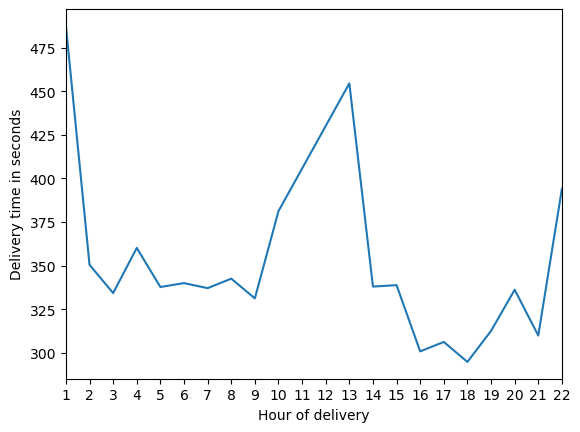

In [95]:
q = """
select hour(segment_end_time) as hr, count(*) as cnt, avg(timestampdiff(second, segment_start_time, segment_end_time)) as t
from route_segments
where TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 and 
TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)<30
group by hr
order by hr
"""
hrdepending = pd.read_sql(q, db)
plt.plot(hrdepending.hr, hrdepending.t)
plt.xlim(1, 22)
plt.xticks(range(1, 23))
plt.xlabel("Hour of delivery")
plt.ylabel("Delivery time in seconds")
hrdepending

,hr,cnt,t
0,2,338,350.5207
1,3,289,334.3080
2,4,310,360.1742
3,5,310,337.7806
4,6,297,340.0202
5,7,324,337.1265
6,8,335,342.5642
7,9,291,331.2680
8,14,297,338.0370
9,15,358,338.8492


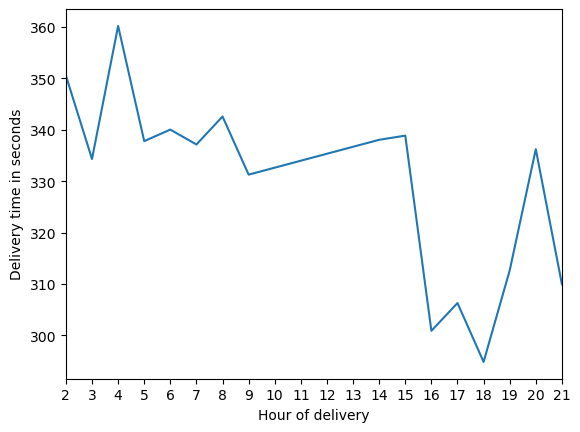

In [98]:
q = """
select hour(segment_end_time) as hr, count(*) as cnt, avg(timestampdiff(second, segment_start_time, segment_end_time)) as t
from route_segments
where TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 and 
TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)<30
group by hr
having cnt>100
order by hr
"""
hrdepending = pd.read_sql(q, db)
plt.plot(hrdepending.hr, hrdepending.t)
plt.xlim(2, 21)
plt.xticks(range(2, 22))
plt.xlabel("Hour of delivery")
plt.ylabel("Delivery time in seconds")
hrdepending

Text(0, 0.5, 'Average delivery time in seconds')

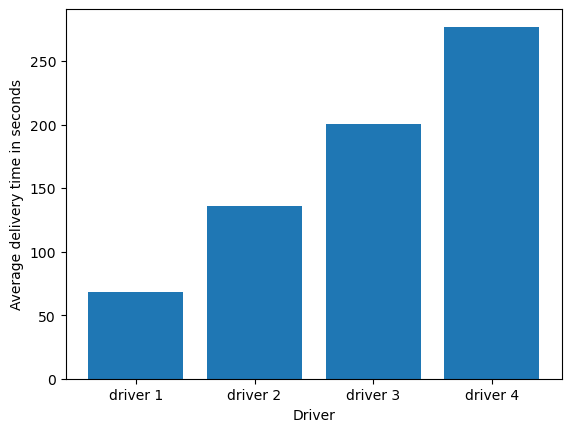

In [19]:
q = """
select driver_id, avg(timestampdiff(second, segment_start_time, segment_end_time)) as t
from route_segments
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 and 
TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)<30 and order_id is not null
group by driver_id
order by driver_id
"""
driverDependingStop = pd.read_sql(q, db)
plt.bar([f"driver {i}" for i in driverDependingStop.driver_id], driverDependingStop.t)
plt.xlabel("Driver")
plt.ylabel("Average delivery time in seconds")

Text(0, 0.5, 'Average length in minutes')

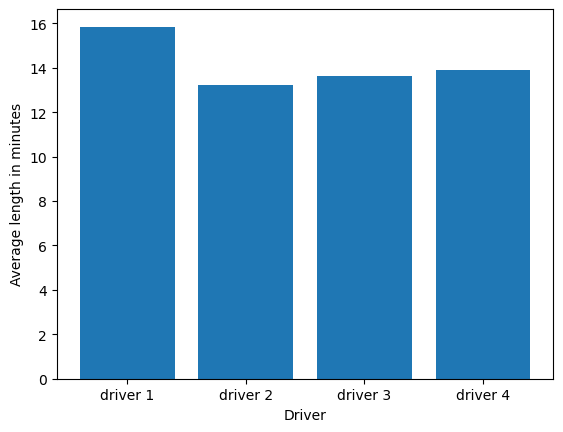

In [26]:
q = """
select driver_id, avg(timestampdiff(minute, segment_start_time, segment_end_time)) as t
from route_segments
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 
and order_id is null
group by driver_id
order by driver_id
"""
driverDependingDrive = pd.read_sql(q, db)
plt.bar([f"driver {i}" for i in driverDependingDrive.driver_id], driverDependingDrive.t)
plt.xlabel("Driver")
plt.ylabel("Average length in minutes")

Text(0, 0.5, 'Average drive length in minutes')

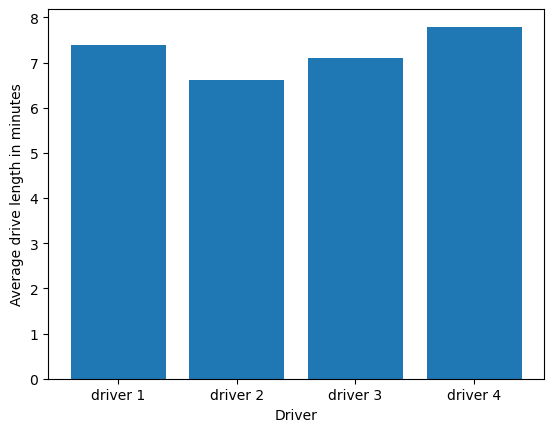

In [28]:
q = """
select driver_id, avg(timestampdiff(minute, segment_start_time, segment_end_time)) as t
from route_segments
where segment_type='DRIVE' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 
group by driver_id
order by driver_id
"""
driverDependingDrive = pd.read_sql(q, db)
plt.bar([f"driver {i}" for i in driverDependingDrive.driver_id], driverDependingDrive.t)
plt.xlabel("Driver")
plt.ylabel("Average drive length in minutes")

In [29]:
q = """
select driver_id, sector_id, count(*) as cnt
from route_segments
join orders using(order_id)
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0
group by driver_id, sector_id
order by driver_id
"""
driverSector = pd.read_sql(q, db)

In [30]:
x = np.arange(len(np.unique(driverSector.driver_id)))
sectors = [driverSector[driverSector.sector_id==i].cnt.to_list() for i in np.unique(driverSector.sector_id)]

(0.0, 280.0)

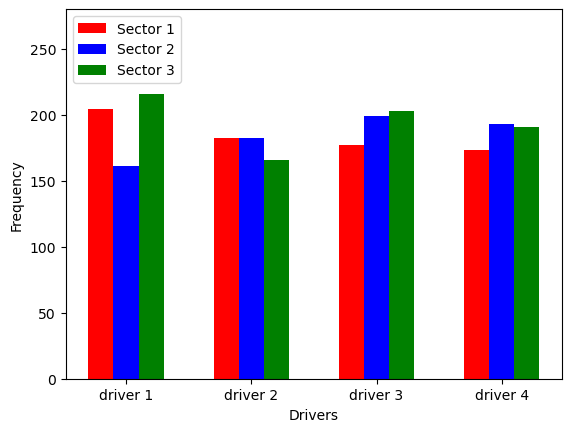

In [106]:
plt.bar(x-0.2, sectors[0], 0.2, color="red")
plt.bar(x, sectors[1], 0.2, color="blue")
plt.bar(x+0.2, sectors[2], 0.2, color="green")
plt.xticks(x, [f"driver {d}" for d in range(1, len(x)+1)]) 
plt.xlabel("Drivers")
plt.ylabel("Frequency")
plt.legend(["Sector 1", "Sector 2", "Sector 3"], loc="upper left") 
plt.ylim(0, 280)

Text(0, 0.5, 'Number of comleted deliveries')

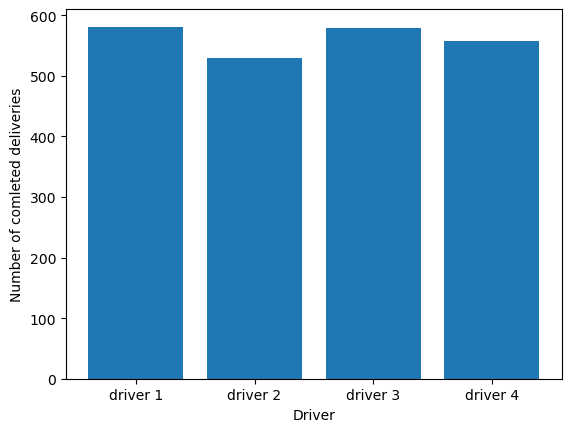

In [37]:
q = """
select driver_id, count(*) as cnt
from route_segments
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0
and order_id is not null
group by driver_id
order by driver_id
"""
driverExperience = pd.read_sql(q, db)
driverExperience = pd.read_sql(q, db)
plt.bar([f"driver {i}" for i in driverExperience.driver_id], driverExperience.cnt)
plt.xlabel("Driver")
plt.ylabel("Number of completed deliveries")

Text(0, 0.5, 'Average weight')

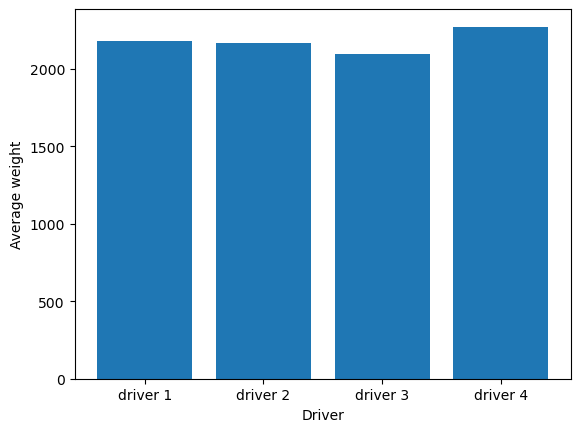

In [42]:
q = """
select driver_id, avg(quantity*weight) as averageWeight
from route_segments
join orders using(order_id)
join orders_products using(order_id)
join products using(product_id)
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0
group by driver_id
order by driver_id
"""
averageWeights = pd.read_sql(q, db)
averageWeights = pd.read_sql(q, db)
plt.bar([f"driver {i}" for i in averageWeights.driver_id], averageWeights.averageWeight)
plt.xlabel("Driver")
plt.ylabel("Average weight")

(0.0, 6.0)

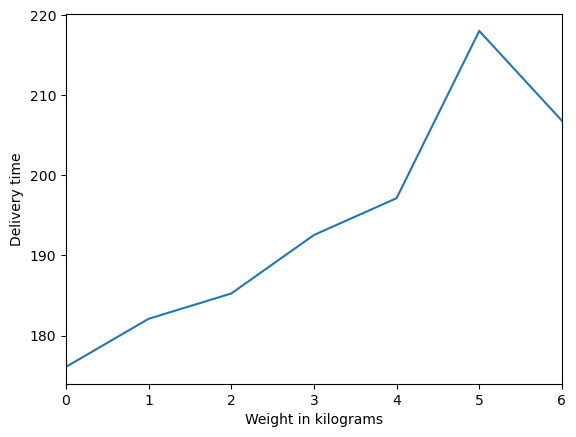

In [67]:
q = """
select round(quantity*weight/1000) as w,
avg(TIMESTAMPDIFF(second, segment_start_time, segment_end_time)) as t,
count(*) as cnt
from route_segments
join orders using(order_id)
join orders_products using(order_id)
join products using(product_id)
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 and
TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)<30
group by round(quantity*weight/1000)
order by w
"""
weights = pd.read_sql(q, db)
plt.plot(weights.w, weights.t)
plt.xlabel("Weight in kilograms")
plt.ylabel("Delivery time")
plt.xlim(0, 6)

In [132]:
q = """
select driver_id, sector_id, avg(hour(segment_end_time)) as deliveryHour, sum(quantity*weight/1000) as weightKg, 
timestampdiff(second, segment_start_time, segment_end_time) as deliveryTime, planned_delivery_duration
from route_segments
join orders using(order_id)
join orders_products using(order_id)
join products using(product_id)
where segment_type='STOP' and TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)>=0 and 
TIMESTAMPDIFF(minute, segment_start_time, segment_end_time)<30
group by order_id, driver_id, sector_id, timestampdiff(second, segment_start_time, segment_end_time), planned_delivery_duration
order by driver_id
"""
data = pd.read_sql(q, db)
data

,driver_id,sector_id,deliveryHour,weightKg,deliveryTime,planned_delivery_duration
0,1,3,20.0,1.977,0,177
1,1,1,4.0,8.703,146,176
2,1,3,15.0,14.685,0,177
3,1,2,9.0,1.754,32,179
4,1,2,3.0,15.715,101,175
...,...,...,...,...,...,...
2204,4,3,5.0,5.825,235,179
2205,4,2,6.0,1.198,179,200
2206,4,2,9.0,7.283,272,175
2207,4,1,16.0,18.189,547,178


In [133]:
X = data.drop(["deliveryTime", "planned_delivery_duration"], axis=1)
y = data.deliveryTime
planned = data.planned_delivery_duration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [135]:
gs = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid={"n_estimators": range(10, 120, 10), "max_depth": range(2, 20, 2)}, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ......max_depth=2, n_estimators=10;, score=0.496 total time=   0.1s
[CV 2/5] END ......max_depth=2, n_estimators=10;, score=0.513 total time=   0.1s
[CV 3/5] END ......max_depth=2, n_estimators=10;, score=0.519 total time=   0.1s
[CV 4/5] END ......max_depth=2, n_estimators=10;, score=0.571 total time=   0.1s
[CV 5/5] END ......max_depth=2, n_estimators=10;, score=0.537 total time=   0.1s
[CV 1/5] END ......max_depth=2, n_estimators=20;, score=0.470 total time=   0.2s
[CV 2/5] END ......max_depth=2, n_estimators=20;, score=0.505 total time=   0.2s
[CV 3/5] END ......max_depth=2, n_estimators=20;, score=0.534 total time=   0.2s
[CV 4/5] END ......max_depth=2, n_estimators=20;, score=0.560 total time=   0.2s
[CV 5/5] END ......max_depth=2, n_estimators=20;, score=0.528 total time=   0.2s
[CV 1/5] END ......max_depth=2, n_estimators=30;, score=0.480 total time=   0.2s
[CV 2/5] END ......max_depth=2, n_estimators=30

[CV 2/5] END .....max_depth=4, n_estimators=100;, score=0.644 total time=   0.3s
[CV 3/5] END .....max_depth=4, n_estimators=100;, score=0.728 total time=   0.3s
[CV 4/5] END .....max_depth=4, n_estimators=100;, score=0.784 total time=   0.3s
[CV 5/5] END .....max_depth=4, n_estimators=100;, score=0.712 total time=   0.3s
[CV 1/5] END .....max_depth=4, n_estimators=110;, score=0.705 total time=   0.3s
[CV 2/5] END .....max_depth=4, n_estimators=110;, score=0.643 total time=   0.3s
[CV 3/5] END .....max_depth=4, n_estimators=110;, score=0.731 total time=   0.3s
[CV 4/5] END .....max_depth=4, n_estimators=110;, score=0.784 total time=   0.3s
[CV 5/5] END .....max_depth=4, n_estimators=110;, score=0.710 total time=   0.3s
[CV 1/5] END ......max_depth=6, n_estimators=10;, score=0.738 total time=   0.1s
[CV 2/5] END ......max_depth=6, n_estimators=10;, score=0.667 total time=   0.1s
[CV 3/5] END ......max_depth=6, n_estimators=10;, score=0.720 total time=   0.1s
[CV 4/5] END ......max_depth

[CV 4/5] END ......max_depth=8, n_estimators=80;, score=0.808 total time=   0.3s
[CV 5/5] END ......max_depth=8, n_estimators=80;, score=0.741 total time=   0.3s
[CV 1/5] END ......max_depth=8, n_estimators=90;, score=0.741 total time=   0.3s
[CV 2/5] END ......max_depth=8, n_estimators=90;, score=0.651 total time=   0.3s
[CV 3/5] END ......max_depth=8, n_estimators=90;, score=0.693 total time=   0.3s
[CV 4/5] END ......max_depth=8, n_estimators=90;, score=0.802 total time=   0.3s
[CV 5/5] END ......max_depth=8, n_estimators=90;, score=0.737 total time=   0.3s
[CV 1/5] END .....max_depth=8, n_estimators=100;, score=0.734 total time=   0.3s
[CV 2/5] END .....max_depth=8, n_estimators=100;, score=0.648 total time=   0.3s
[CV 3/5] END .....max_depth=8, n_estimators=100;, score=0.704 total time=   0.3s
[CV 4/5] END .....max_depth=8, n_estimators=100;, score=0.809 total time=   0.3s
[CV 5/5] END .....max_depth=8, n_estimators=100;, score=0.736 total time=   0.3s
[CV 1/5] END .....max_depth=

[CV 1/5] END .....max_depth=12, n_estimators=70;, score=0.720 total time=   0.3s
[CV 2/5] END .....max_depth=12, n_estimators=70;, score=0.633 total time=   0.3s
[CV 3/5] END .....max_depth=12, n_estimators=70;, score=0.680 total time=   0.3s
[CV 4/5] END .....max_depth=12, n_estimators=70;, score=0.789 total time=   0.3s
[CV 5/5] END .....max_depth=12, n_estimators=70;, score=0.729 total time=   0.3s
[CV 1/5] END .....max_depth=12, n_estimators=80;, score=0.727 total time=   0.3s
[CV 2/5] END .....max_depth=12, n_estimators=80;, score=0.634 total time=   0.3s
[CV 3/5] END .....max_depth=12, n_estimators=80;, score=0.665 total time=   0.3s
[CV 4/5] END .....max_depth=12, n_estimators=80;, score=0.793 total time=   0.3s
[CV 5/5] END .....max_depth=12, n_estimators=80;, score=0.722 total time=   0.3s
[CV 1/5] END .....max_depth=12, n_estimators=90;, score=0.723 total time=   0.3s
[CV 2/5] END .....max_depth=12, n_estimators=90;, score=0.643 total time=   0.3s
[CV 3/5] END .....max_depth=

[CV 3/5] END .....max_depth=16, n_estimators=50;, score=0.662 total time=   0.2s
[CV 4/5] END .....max_depth=16, n_estimators=50;, score=0.787 total time=   0.2s
[CV 5/5] END .....max_depth=16, n_estimators=50;, score=0.724 total time=   0.2s
[CV 1/5] END .....max_depth=16, n_estimators=60;, score=0.729 total time=   0.3s
[CV 2/5] END .....max_depth=16, n_estimators=60;, score=0.633 total time=   0.3s
[CV 3/5] END .....max_depth=16, n_estimators=60;, score=0.676 total time=   0.3s
[CV 4/5] END .....max_depth=16, n_estimators=60;, score=0.791 total time=   0.3s
[CV 5/5] END .....max_depth=16, n_estimators=60;, score=0.727 total time=   0.4s
[CV 1/5] END .....max_depth=16, n_estimators=70;, score=0.718 total time=   0.3s
[CV 2/5] END .....max_depth=16, n_estimators=70;, score=0.627 total time=   0.3s
[CV 3/5] END .....max_depth=16, n_estimators=70;, score=0.657 total time=   0.3s
[CV 4/5] END .....max_depth=16, n_estimators=70;, score=0.778 total time=   0.3s
[CV 5/5] END .....max_depth=

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': range(2, 20, 2),
                         'n_estimators': range(10, 120, 10)},
             verbose=3)

In [136]:
gs.best_params_

{'max_depth': 6, 'n_estimators': 40}

In [137]:
rfr = RandomForestRegressor(n_estimators=gs.best_params_["n_estimators"], max_depth=gs.best_params_["max_depth"]).fit(X_train, y_train)
mean_squared_error(rfr.predict(X_test), y_test)

2600.758976961244

In [138]:
mean_squared_error(planned, y)

13520.674060660933